# Segmantic Segmentation with VGG16

The initial attempt with using a GAN hit a wall, specifically with figuring out how to do proper layer sizing for the transposed convolution layers for the generator. On top of that, some research I did during my "off" time showed that the approach semantic segmentation using either an FCN (Fully Convolutional Network) approach or SegNet would work best.

Since SegNet is completely new, whereas transfer learning with VGG16 is something I'm familiar with, I'm going to attempt a VGG16 network here.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from random import randint
from glob import glob
import os
import os.path
import scipy

%matplotlib inline

import tensorflow as tf
#Check GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print('TensorFlow Version: {}'.format(tf.__version__))

Default GPU Device: /device:GPU:0
TensorFlow Version: 1.6.0


In [2]:
#useful variables
num_classes = 13 # none and 12 options, 0-12
image_shape = (160, 576)
# image_shape = (576, 160)
weights_initializer_stddev = 0.01
weights_regularized_l2 = 1e-3

## Load VGG16


First we're going to load VGG16 with pretrained weights (so it maintains its feature detectors, which can be useful for our smaller dataset).

In [3]:
#Download VGG16 if it is not already
from urllib.request import urlretrieve
import zipfile

if not os.path.exists("vgg16.zip"):
    urlretrieve(
        'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip',
        "./vgg16.zip")
    print("Downloaded VGG16 model weights")
else:
    print("Already exists, skipping download")

Already exists, skipping download


In [4]:
#Extract if needed
if not os.path.exists("./vgg"):
    unzip = zipfile.ZipFile("./vgg16.zip", "r")
    unzip.extractall("./")
    unzip.close()
    print("Extracted VGG16 model weights")
else:
    print("Already exists, skipping extraction")

Already exists, skipping extraction


### Helper Functions

First a couple of helper functions. Our output is an array of as any dimensions as we have classes - 13 by default, 3 for the given challenge.

The data comes in with all data on the red channel - 0-12 for the given class. I need to be able to return this format as well, so I have to convert from this image format to the multi-dimensional array - and vice versa.

In [5]:
#Make a map more colorful
def convertToColor(value):
    colors = [
        (255, 255, 255),   #0
        (255, 0, 0),      #1
        (0, 255, 0),      #2
        (0, 0, 255),      #3
        (255, 255, 0),    #4
        (127, 0, 255),    #5
        (51, 255, 51),    #6
        (255, 0, 127),    #7
        (127, 127, 127),  #8
        (0, 0, 0),        #9
        (0, 255, 255),  #10
        (0, 0, 100),      #11
        (100, 0, 0),      #12
    ]
    return colors[value[0]]

def colorizeMap(img):
    return [list( map(convertToColor, row) ) for row in img]

In [6]:
#We need to be able to convert the image map to a 13 channel ground truth map, and vice versa
def pixelToTruth(value):
    truths = [
        (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)
    ]
    
    return truths[value[0]]

def truthToPixel(value):
    tmp = value.tolist()
    return (tmp.index(max(tmp)), 0, 0)

def imageToTruth(img):
    return [list(map(pixelToTruth, row)) for row in img]

def truthToImage(truth):
    return [list(map(truthToPixel, row)) for row in truth]

The below creates a batch iterator for us for training

In [7]:
# Function to load the image data and the label for it
def get_training_data(batch_size):
    #Both inputs and ground truth maps have the same name - easy!
    image_paths = glob(os.path.join("./data/Train/CameraRGB", "*.png"))
    label_paths = glob(os.path.join("./data/Train/CameraSeg", "*.png"))
    
    for batch in range(0, len(image_paths), batch_size):
        images = []
        maps = []
    
    for batch in range(0, len(image_paths), batch_size):
        images = []
        maps = []
        
        for index, image_file in enumerate(image_paths[batch:batch + batch_size]):
            map_file = os.path.join(label_paths[index])
            
            image = scipy.misc.imread(image_file)
            image = scipy.misc.imresize(image, image_shape)
#             image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
            map_image = scipy.misc.imread(map_file)
            map_image = scipy.misc.imresize(map_image, image_shape)
            map_image = imageToTruth(map_image)
            
            images.append(image)
            maps.append(map_image)

        yield np.array(images), np.array(maps)
            
            

We're going to use the `model` object to keep track of each layer of our deep net for easy reference and debugging.

In [8]:
#Deep learning model
model = {}

Generate placeholders

In [9]:
def get_placeholders(model):
    model['placeholders'] = {}
    
    #Placeholders
    model['placeholders']['label'] = tf.placeholder(tf.int32, (None, image_shape[0], image_shape[1], model['settings']['num_classes']), name='label')
    model['placeholders']['learning_rate'] = tf.placeholder(tf.float32, name='learning_rate')

Load the VGG and pull out key aspects (keep_prob) andlayers (input, layers 3, 4, and 7)

In [10]:
def load_vgg(model):
    #Grab layers from pretrained VGG
    tf.saved_model.loader.load(sess, ["vgg16"], "./vgg/")
    
    model['graph'] = tf.get_default_graph()
    
    #define key layers for us to work with, so we can take pieces of VGG16
    #for our own use
    model['input_layer'] = model['graph'].get_tensor_by_name("image_input:0")
    model['keep_prob'] = model['graph'].get_tensor_by_name("keep_prob:0") #Dropout settings
    
    #more layer grabbing
    model['layer_3'] = model['graph'].get_tensor_by_name("layer3_out:0")
    model['layer_4'] = model['graph'].get_tensor_by_name("layer4_out:0")
    model['layer_7'] = model['graph'].get_tensor_by_name("layer7_out:0")

Build the FCN off of the VGG

In [16]:
def vgg_fcn(model):
    # Skip connections for later
    model['skip_conv_3'] = tf.layers.conv2d(model['layer_3'], model['settings']['num_classes'], 1, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2))
    
    model['skip_conv_4'] = tf.layers.conv2d(model['layer_4'], model['settings']['num_classes'], 1, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2))
    
    #Layer 7 isn't skipped, it's passed right to transpose    
    model['fully_connected_convs'] = tf.layers.conv2d(model['layer_7'], model['settings']['num_classes'], 1, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2))
    
    #From layer 7 we need to transpose up
    model['transpose_1'] = tf.layers.conv2d_transpose(model['fully_connected_convs'], model['settings']['num_classes'], 4, 2, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2))
    
    # Add the skip layer from layer 4
    model['skip_1'] = tf.add(model['transpose_1'], model['skip_conv_4'])
    
    #Tranpose up from resultant layer
    model['transpose_2'] = tf.layers.conv2d_transpose(model['skip_1'], model['settings']['num_classes'], 4, 2, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2))
    
    #Create skip layer from layer 3
    model['skip_2'] = tf.add(model['skip_conv_3'], model['transpose_2'])
    
    #Final output layer
    model['output_layer'] = tf.layers.conv2d_transpose(model['skip_2'], model['settings']['num_classes'], 16, 8, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev=weights_initializer_stddev),
            kernel_regularizer= tf.contrib.layers.l2_regularizer(weights_regularized_l2),
            activation=tf.sigmoid)
    
    return model['output_layer']

In [12]:
def vgg_fcn(model):
    # Skip connections for later
    model['skip_conv_3'] = tf.layers.conv2d(model['layer_3'], model['settings']['num_classes'], 1, padding='same')
    
    model['skip_conv_4'] = tf.layers.conv2d(model['layer_4'], model['settings']['num_classes'], 1, padding='same')
    
    #Layer 7 isn't skipped, it's passed right to transpose    
    model['fully_connected_convs'] = tf.layers.conv2d(model['layer_7'], model['settings']['num_classes'], 1, padding='same')
    
    #From layer 7 we need to transpose up
    model['transpose_1'] = tf.layers.conv2d_transpose(model['fully_connected_convs'], model['settings']['num_classes'], 4, 2, padding='same')
    
    # Add the skip layer from layer 4
    model['skip_1'] = tf.add(model['transpose_1'], model['skip_conv_4'])
    
    #Tranpose up from resultant layer
    model['transpose_2'] = tf.layers.conv2d_transpose(model['skip_1'], model['settings']['num_classes'], 4, 2, padding='same')
    
    #Create skip layer from layer 3
    model['skip_2'] = tf.add(model['skip_conv_3'], model['transpose_2'])
    
    #Final output layer
    model['output_layer'] = tf.layers.conv2d_transpose(model['skip_2'], model['settings']['num_classes'], 16, 8, padding='same',
                                activation=tf.sigmoid, name="output_layer")
    
    return model['output_layer']

Generate logits

In [13]:
def get_logits(model):
    model['logits'] = {}
    
    #Create the optimzer
    model['logits']['logits'] = tf.reshape(model['output_layer'], (-1, model['settings']['num_classes']))
    model['logits']['correct_label'] = tf.reshape(model['placeholders']['label'], (-1, model['settings']['num_classes']))

Create loss functions and training operation

In [14]:
def get_loss(model):
    model['loss'] = {}
    
    model['loss']['softmax'] = tf.nn.softmax_cross_entropy_with_logits_v2(logits=model['logits']['logits'], labels=model['logits']['correct_label'])
    model['loss']['cross_entropy_loss'] = tf.reduce_mean(model['loss']['softmax'])
    model['loss']['optimizer'] = tf.train.AdamOptimizer(learning_rate=model['placeholders']['learning_rate'])
    model['loss']['train_op'] = model['loss']['optimizer'].minimize(model['loss']['cross_entropy_loss'])

Model traning function

In [15]:
def train(sess, model, epochs=1, batch_size=10, keep_probability=0.5, learning_rate_alpha=0.001):
    
    sess.run(tf.global_variables_initializer())
    
    print("Graph has been built - launching training")
    print("====== :-) ======")
    print()
    
    for epoch in range(epochs):
        print("Launching Epoch {}".format(epoch))
        loss_log = []
        batch_count = 0
        
        #get the images
        for image, truth in get_training_data(batch_size):
            batch_count += 1
            _, loss = sess.run(
                    [model['loss']['train_op'], model['loss']['cross_entropy_loss']],
                    feed_dict = {
                        model['input_layer']: image,
                        model['placeholders']['label']: truth,
                        model['keep_prob']: keep_probability,
                        model['placeholders']['learning_rate']: learning_rate_alpha
                    }
                )
            loss_log.append('{:3f}'.format(loss))
            if(batch_count % 10 == 0):
                print("Batch {} - loss of {}".format(batch_count, loss))
        print("Training for epoch finished - ", loss_log[-1])
        chkpt_path = "./chkpts/model_epoch_{}/fcn_model".format(epoch)
        saver.save(sess, chkpt_path)
        print("Model saved as {}".format(chkpt_path))
        print()
    print("Training finished")

Combine the above functions for building our net and use them below to run the net and train it.

Note that as of this run, we're using 13 classes, whereas our actual network uses 3. This is really just to see if it trains decently well and what our output is like. I'll only run 10 epochs. and see what I can get

In [20]:
saver = None

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 13 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
 
    train(sess, model, 10, 10, 0.75, 0.0001)
  

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'
Graph has been built - launching training
====== :-) ======

Launching Epoch 0


/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Batch 10 - loss of 2.4074511528015137
Batch 20 - loss of 2.2703957557678223
Batch 30 - loss of 2.2055447101593018
Batch 40 - loss of 2.168469190597534
Batch 50 - loss of 2.139244794845581
Batch 60 - loss of 2.121276378631592
Batch 70 - loss of 2.106870412826538
Batch 80 - loss of 2.0935959815979004
Batch 90 - loss of 2.0826127529144287
Batch 100 - loss of 2.0739877223968506
Training for epoch finished -  2.073988
Model saved as ./chkpts/model_epoch_0/fcn_model

Launching Epoch 1
Batch 10 - loss of 2.067110061645508
Batch 20 - loss of 2.0604491233825684
Batch 30 - loss of 2.052419662475586
Batch 40 - loss of 2.047424793243408
Batch 50 - loss of 2.0387086868286133
Batch 60 - loss of 2.03397274017334
Batch 70 - loss of 2.028926372528076
Batch 80 - loss of 2.0235238075256348
Batch 90 - loss of 2.019969940185547
Batch 100 - loss of 2.017677068710327
Training for epoch finished -  2.017677
Model saved as ./chkpts/model_epoch_1/fcn_model

Launching Epoch 2
Batch 10 - loss of 2.014107465744018

After training above, we don't have great results, but let's see what the network is doing.

I didn't expect great results - given the very tiny size of the dataset and the number of classes we have to define, I'd expect poor results. This is mostly to ensure we don't have any oddities in training and the network architecture *can* learn, and that our output looks even somewhat "correct".

In [98]:
def execute_on_image(sess, model):

    chosen_image = "165"
    image_file = "./data/Train/CameraRGB/{}.png".format(chosen_image)
    truth_file = "./data/Train/CameraSeg/{}.png".format(chosen_image)
    
    image = scipy.misc.imread(image_file)
    image = scipy.misc.imresize(image, image_shape)
    plt.figure()
    plt.imshow(image)
    
#     image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
    
    truth = scipy.misc.imread(truth_file)
    truth = scipy.misc.imresize(truth, image_shape)
    plt.figure()
    plt.imshow(colorizeMap(truth))
    truth = imageToTruth(truth)
    
    output = sess.run(model["output_layer"], feed_dict={
            model["input_layer"]: [image],
            model['placeholders']['label'] : [truth],
            "keep_prob:0": 1.0,
            model["placeholders"]["learning_rate"] : 0.01
        })
    output = output[0]
    
    plt.figure()
    outputImage = truthToImage(output)
    colorizedOutput = colorizeMap(outputImage)
    plt.imshow(colorizedOutput)
    
    return output

In [99]:
saver = None

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./chkpts/model_epoch_9/fcn_model


/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernela

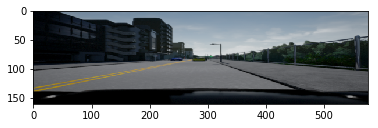

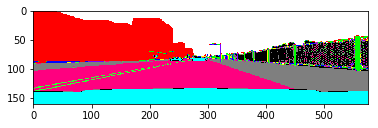

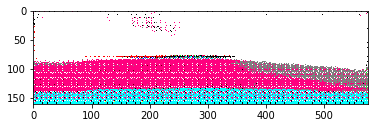

In [100]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 13 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_9/fcn_model')
    
    results = execute_on_image(sess, model)

Not too bad for such a high loss - it mostly gets the car hood and the road - definitely didn't get the buildings or the fence posts.

I saved the model used for above as `13_classes_model.zip`

## Moving over to just 3 classes

With the dataset at the size it is, this network would never reach the level of clarity needed for all 13 classes. I'm going to now change some of the helper functions to convert data into a 3 class system - `roads`, `vehicles`, and `none`. This should make the network quite a bit better as it has less to learn.

In [17]:
#We need to be able to convert the image map to a 13 channel ground truth map, and vice versa
def pixelToTruth(value):
    if value[0] == 7:
        return (0, 1, 0)
    elif value[0] == 10:
        return (0, 0, 1)
    else:
        return (1, 0, 0)

In [18]:
saver = None

tf.reset_default_graph()

with tf.Session() as sess:
    
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
 
    train(sess, model, 50, 10, 0.5, 0.0001)
  

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'
Graph has been built - launching training
====== :-) ======

Launching Epoch 0


/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Batch 10 - loss of 1.0257612466812134
Batch 20 - loss of 0.9213919639587402
Batch 30 - loss of 0.8357688188552856
Batch 40 - loss of 0.7608398199081421
Batch 50 - loss of 0.7218383550643921
Batch 60 - loss of 0.7059884071350098
Batch 70 - loss of 0.6793964505195618
Batch 80 - loss of 0.6667607426643372
Batch 90 - loss of 0.6542140245437622
Batch 100 - loss of 0.6494996547698975
Training for epoch finished -  0.649500
Model saved as ./chkpts/model_epoch_0/fcn_model

Launching Epoch 1
Batch 10 - loss of 0.642705500125885
Batch 20 - loss of 0.6414515972137451
Batch 30 - loss of 0.6394054293632507
Batch 40 - loss of 0.6365676522254944
Batch 50 - loss of 0.6303033232688904
Batch 60 - loss of 0.63392573595047
Batch 70 - loss of 0.6298521161079407
Batch 80 - loss of 0.6263188123703003
Batch 90 - loss of 0.6246912479400635
Batch 100 - loss of 0.623431384563446
Training for epoch finished -  0.623431
Model saved as ./chkpts/model_epoch_1/fcn_model

Launching Epoch 2
Batch 10 - loss of 0.6207390

Model saved as ./chkpts/model_epoch_16/fcn_model

Launching Epoch 17
Batch 10 - loss of 0.6000978350639343
Batch 20 - loss of 0.603350043296814
Batch 30 - loss of 0.6001851558685303
Batch 40 - loss of 0.6002041697502136
Batch 50 - loss of 0.6000341773033142
Batch 60 - loss of 0.5996191501617432
Batch 70 - loss of 0.6006583571434021
Batch 80 - loss of 0.5989270210266113
Batch 90 - loss of 0.5994349718093872
Batch 100 - loss of 0.6008070111274719
Training for epoch finished -  0.600807
Model saved as ./chkpts/model_epoch_17/fcn_model

Launching Epoch 18
Batch 10 - loss of 0.6007532477378845
Batch 20 - loss of 0.6028717756271362
Batch 30 - loss of 0.6008272171020508
Batch 40 - loss of 0.5999783277511597
Batch 50 - loss of 0.6007131338119507
Batch 60 - loss of 0.5998174548149109
Batch 70 - loss of 0.5996436476707458
Batch 80 - loss of 0.6006027460098267
Batch 90 - loss of 0.5992445945739746
Batch 100 - loss of 0.5988875031471252
Training for epoch finished -  0.598888
Model saved as ./chkp

Batch 90 - loss of 0.5941195487976074
Batch 100 - loss of 0.5933250188827515
Training for epoch finished -  0.593325
Model saved as ./chkpts/model_epoch_33/fcn_model

Launching Epoch 34
Batch 10 - loss of 0.5925096869468689
Batch 20 - loss of 0.5932551622390747
Batch 30 - loss of 0.5979443192481995
Batch 40 - loss of 0.593737006187439
Batch 50 - loss of 0.5945345759391785
Batch 60 - loss of 0.5939303040504456
Batch 70 - loss of 0.5935526490211487
Batch 80 - loss of 0.5950049757957458
Batch 90 - loss of 0.5935842990875244
Batch 100 - loss of 0.5924326181411743
Training for epoch finished -  0.592433
Model saved as ./chkpts/model_epoch_34/fcn_model

Launching Epoch 35
Batch 10 - loss of 0.5921769738197327
Batch 20 - loss of 0.5948184132575989
Batch 30 - loss of 0.5958186984062195
Batch 40 - loss of 0.5947491526603699
Batch 50 - loss of 0.593640148639679
Batch 60 - loss of 0.593649685382843
Batch 70 - loss of 0.5931062698364258
Batch 80 - loss of 0.5925801396369934
Batch 90 - loss of 0.59

Loss looks far better than before as I expected. Obviously we're purposely overfitting here - no sense in combatting overfitting on the first go-through (though with a dropout of `0.5` we're pretty good - but I'm not holding back any for generalized validation testing, or doing any data augmentation atm. Let's look at an example output just as before.

I'll have to modify the `execute_on_image` function in order to prepare it for the 3 class pictures and draw them correctly. Note that the truth images, since it's labeling their classes as different #'s (out of 13 still) - the colors will be different - we're looking for similar clustering.

In [36]:
def execute_on_image(sess, model, chosen_image):

    image_file = "./data/Train/CameraRGB/{}.png".format(chosen_image)
    truth_file = "./data/Train/CameraSeg/{}.png".format(chosen_image)
    
    image = scipy.misc.imread(image_file)
    image = scipy.misc.imresize(image, image_shape)
    plt.figure(figsize=(20,15))
    plt.imshow(image)
    
#     image = image - np.array([123.68, 116.779, 103.939], dtype=np.float32)
    
    truth = scipy.misc.imread(truth_file)
    truth = scipy.misc.imresize(truth, image_shape)
    # We're going to convert the truth to an image and back -
    # inefficient, but it should shape it back to the 
    # 3 classes
#     truth = imageToTruth(truthToImage(truth))
    plt.figure(figsize=(20,15))
    plt.imshow(colorizeMap(truth))
    truth = imageToTruth(truth)
    
    output = sess.run(model["output_layer"], feed_dict={
            model["input_layer"]: [image],
            model['placeholders']['label'] : [truth],
            "keep_prob:0": 1.0,
            model["placeholders"]["learning_rate"] : 0.01
        })
    output = output[0]
    
    plt.figure(figsize=(20,15))
    outputImage = truthToImage(output)
    colorizedOutput = colorizeMap(outputImage)
    plt.imshow(colorizedOutput)
    
#     plt.figure(figsize=(20,15))
#     overlayed = cv2.addWeighted(image, 1.0, colorizedOutput, 0.5, 0)
#     plt.imshow(overlayed)
    
    return output

As a note, the model for this is saved as `3_classes_model.zip`.

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./chkpts/model_epoch_49/fcn_model


/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


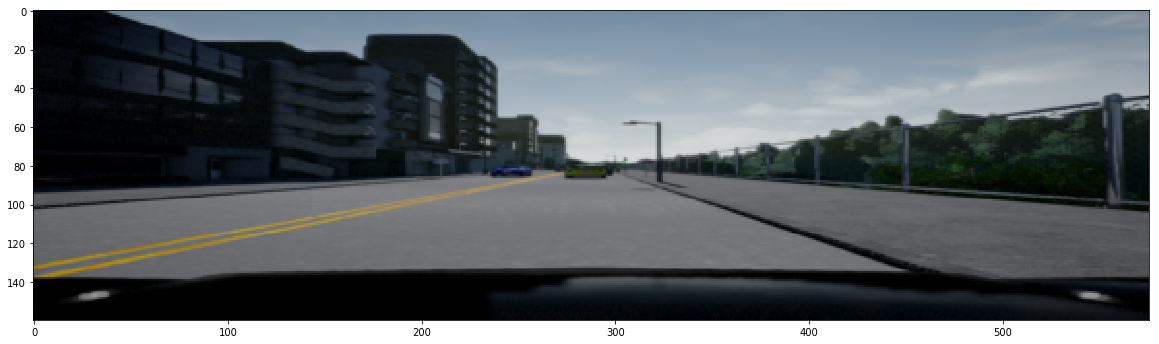

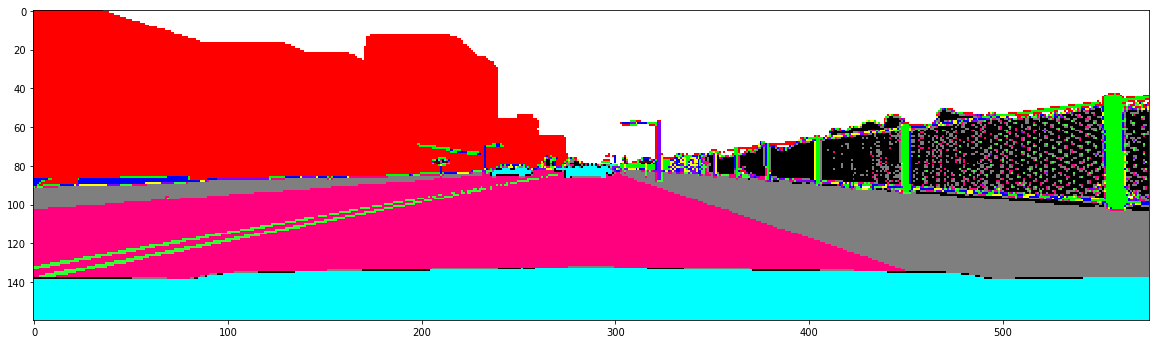

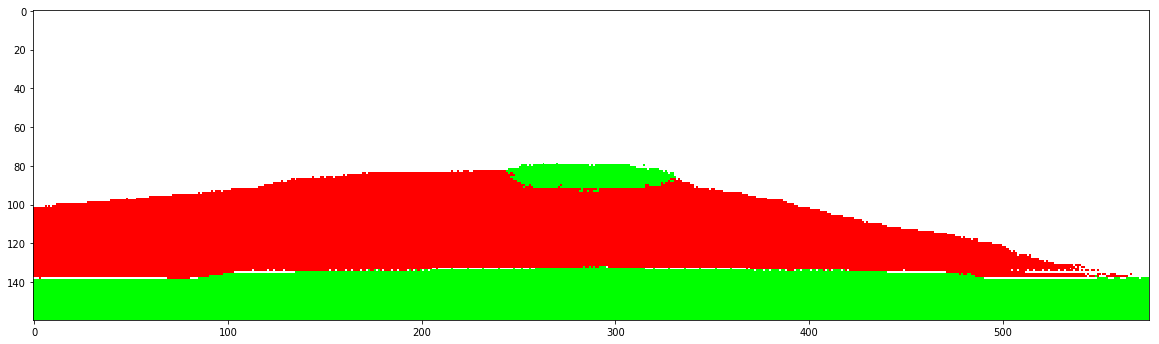

In [37]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_49/fcn_model')
    
    results = execute_on_image(sess, model, "165")

Initial thought - the hood is problematic, but makes sense - the dataset always marks that as a car, so any pipeline that would work with this data would have to remove it anyway. As for the cars- it's not as fine-tuned as before, but it worked out pretty well - it *did* detect those as cars. Let's try another.

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./chkpts/model_epoch_49/fcn_model


/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


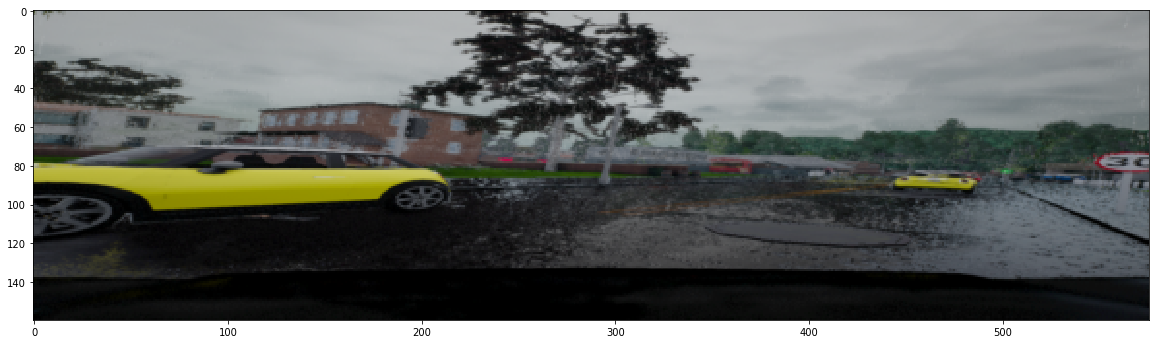

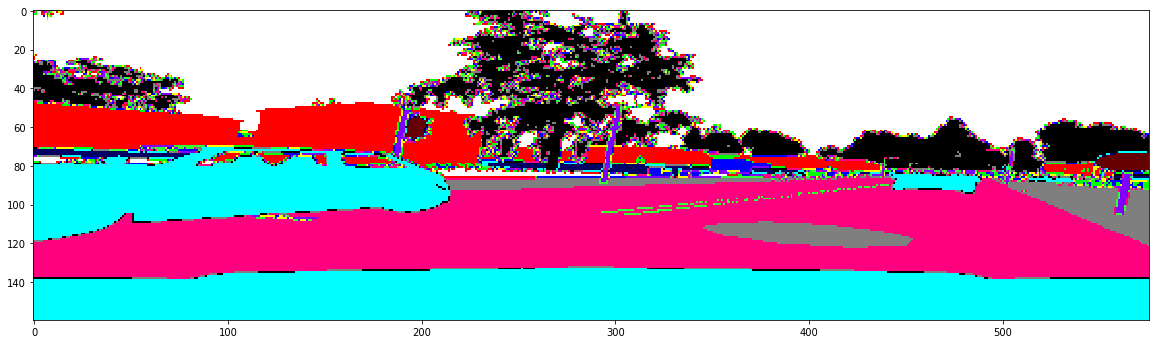

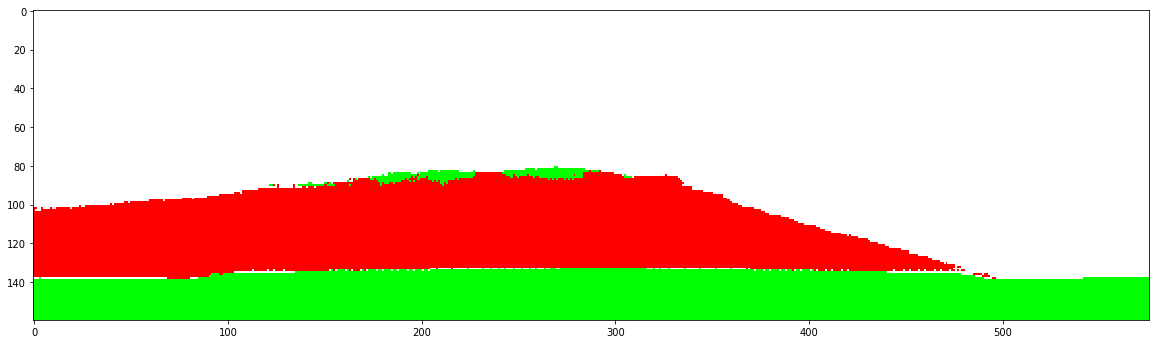

In [38]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_49/fcn_model')
    
    results = execute_on_image(sess, model, "396")

Here the results are less good - it seems the network doesn't quite get the car on the left - could be data, could be network.

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./chkpts/model_epoch_49/fcn_model


/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/home/keith/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


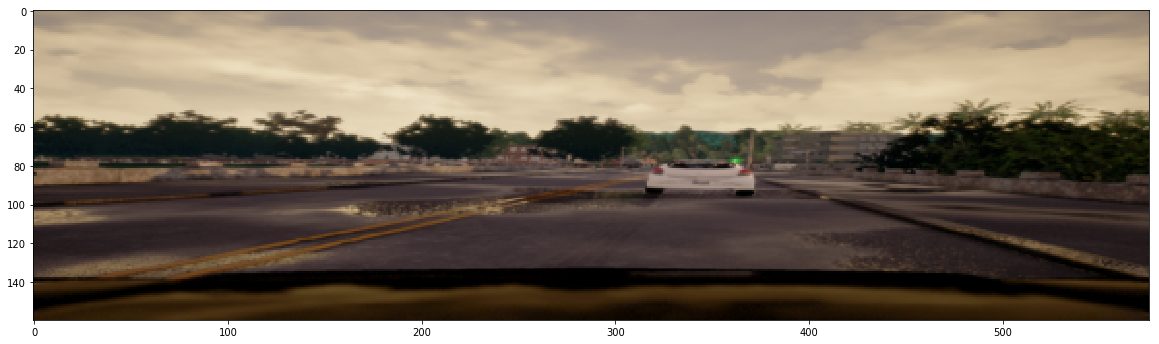

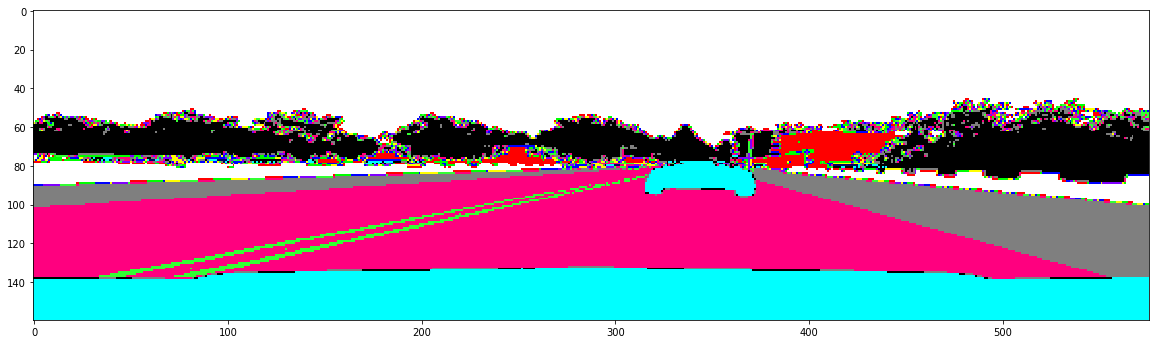

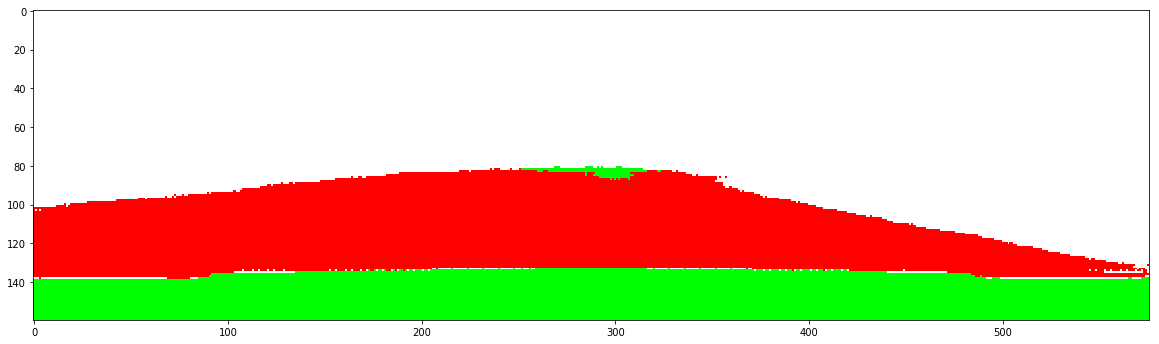

In [39]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = {}
    model['settings'] = { "num_classes": 3 }
    get_placeholders(model)
    load_vgg(model)
    vgg_fcn(model)
    get_logits(model)
    get_loss(model)
    
    saver = tf.train.Saver()
#     saver = tf.train.import_meta_graph("./chkpts/model_epoch_9/checkpoint")
    saver.restore(sess, './chkpts/model_epoch_49/fcn_model')
    
    results = execute_on_image(sess, model, "633")

After seeomg this, it seems that the network kind of just likes to identify cars as down range, and as a result is often right. It's not generalizing super well as is.